### T-Period Parent-Child Interaction Model with Human Capital Investment

Solves a $T$-period dynamic model where a family, consisting of a parent and a child, makes decisions over parental consumption, child's study time, education expenditure, parental labor supply, and child care time to maximize a weighted sum of their lifetime utilities. The utility function incorporates parental consumption, leisure for both parent and child, and the child's human capital, reflecting preferences over these elements and investment in the child's future human capital.

#### Model Description

The model is solved backwards from period $T$ to period 1. At each period $t = 1, \dots, T-1$, the family chooses:

- **Parental consumption** $c_{p,t} > 0$
- **Child's study time** $\tau_{c,t} \in [0, 1]$
- **Education expenditure** $e_{p,t} > 0$
- **Parental labor supply** $h_{p,t} \in [0, 1]$
- **Child care time** $\tau_{p,t} \in [0, 1]$

to maximize the value function:

- **Utility of the parent:**
  $$
  U_{p,t} = \phi_1 \log c_{p,t} + \phi_2 \log (1 - h_{p,t} - \tau_{p,t}) + \tilde{\mu}_t \cdot \phi_3 \log HC_t
  $$
- **Utility of the child:**
  $$
  U_{c,t} = (1 - \tilde{\mu}_t) \cdot (\lambda_1 \log (1 - \tau_{p,t} - \tau_{c,t}) + \lambda_2 \log HC_t)
  $$
- **Value function:**
  $$
  V_t(a_t, k_t, HC_t) = \max_{c_{p,t}, \tau_{c,t}, e_{p,t}, h_{p,t}, \tau_{p,t}} \left\{ U_{p,t} + U_{c,t} + \beta V_{t+1}(a_{t+1}, k_{t+1}, HC_{t+1}) \right\}
  $$



$$
\tilde{\mu}_t =
\begin{cases}
= 1           & \text{if } t \leq 7 \\ 
= 1 - \mu_1 (t-7) & \text{if } 7 < t \leq T
\end{cases}
$$

subject to the following constraints:



- **Budget constraint**:
  $$
  a_{t+1} = (1 + r) a_t + w_t h_{p,t} + y - c_{p,t} - e_{p,t} \geq a_{\min}
  $$
- **Parent's human capital accumulation**:
  $$
  k_{t+1} = k_t + h_{p,t}
  $$
- **Child's human capital technology**:
$$
\log HC_{t+1} =
\begin{cases}
\log R_t + \sigma_{1t} \log \tau_{p,t} + \sigma_{2t} \log e_{p,t} + \sigma_{3t} \log HC_t & \text{if } t \leq 7 \\[2ex]
\log R_t + \sigma_{1t} \log \tau_{p,t} + \sigma_{2t} \log e_{p,t} + \sigma_{3t} \log HC_t + \sigma_{4t} \log \tau_{c,t} & \text{if } t > 7
\end{cases}
$$
- **Wage function**:
  $$
  w_t = (1 - \text{TR}) \cdot w_0 \cdot (1 + \alpha k_t)
  $$
- **Time constraints**:
  - Parent's time:
    $$
    h_{p,t} + \tau_{p,t} \leq 0.8
    $$
  - Child's time:
    $$
    \tau_{c,t} + \tau_{p,t} \leq 0.7
    $$

**Terminal Value at Period $T$**
$$
V_T = \psi_{\text{terminal}} \cdot \log HC_{T+1} + \kappa_{\text{termianl}} \cdot \log a_{T+1}
$$

Where:
- $a_t$: Assets at the beginning of period $t$
- $k_t$: Parent's human capital (cumulative labor supply)
- $HC_t$: Child's human capital level
- $w_t$: After-tax wage rate per unit of labor
- $y$: Unearned income
- $r$: Interest rate
- $\beta$: Discount factor
- $\mu_t$: Bargaining weight for the parent

---

In [2]:
using Random, NLopt, LinearAlgebra, Interpolations, Base.Threads, DataFrames
using Plots, Statistics, ProgressMeter, ForwardDiff, Distributions, Profile
using DataFrames, Measures, StatsBase, LaTeXStrings, Printf, ForwardDiff, Logging
using StaticArrays: SVector

In [ ]:
# -------------------------------
# Utility: Nonlinear Grid Creator
# -------------------------------
function nonlinspace(start::Float64, stop::Float64, num::Int, curv::Float64)
    lin_vals = range(0, stop=1, length=num)
    curved_vals = lin_vals .^ curv
    return start .+ (stop - start) .* curved_vals
end

function create_focused_grid(a_min::Float64, a_focus::Float64, a_max::Float64, Na::Int, focus_share::Float64, curv::Float64)
    Na_focus = ceil(Int, Na * focus_share)
    Na_rest = Na - Na_focus
    grid_focus = nonlinspace(a_min, a_focus, Na_focus, curv)
    grid_rest = nonlinspace(a_focus, a_max, Na_rest + 1, curv)[2:end]
    return vcat(grid_focus, grid_rest)
end

# -------------------------------
# Dynamic Family Model Definition
# -------------------------------
using Random

mutable struct Parent_child_interaction_age_specific
    # --- Model Parameters ---
    T::Int                        # Number of periods
    beta_vector::Vector{Float64}                 # Discount factor
    phi_1_vector::Vector{Float64}                # Parent's disutility of labor
    phi_2_vector::Vector{Float64}                # Parent's utility from human capital
    phi_3_vector::Vector{Float64}                # Parent's utility from consumption
    R_vector::Vector{Float64}                    # Human capital technology parameter
    sigma_1_vector::Vector{Float64}              # Elasticity: HC w.r.t. child care time
    sigma_2_vector::Vector{Float64}              # Elasticity: HC w.r.t. investment
    sigma_3_vector::Vector{Float64}              # Elasticity: HC w.r.t. current human capital
    sigma_4_vector::Vector{Float64}              # Elasticity: HC w.r.t. child's own study time
    lambda_1_vector::Vector{Float64}             # Child's utility of labor
    lambda_2_vector::Vector{Float64}             # Child's utility from human capital
    mu_vector::Vector{Float64}                   # Parameter for bargining inside the family
    tau::Float64                  # Labor income tax
    r::Float64                    # Interest rate
    y::Float64                    # Unearned income
    a_max::Float64                # Max asset level
    a_min::Float64                # Min asset level
    Na::Int                       # Asset grid size
    k_max::Float64                # Max physical capital
    k_min::Float64                # Min physical capital
    Nk::Int                       # Physical capital grid size
    hc_max::Float64               # Max human capital (for child/parent)
    hc_min::Float64               # Min human capital
    Nhc::Int                      # Human capital grid size
    alpha::Float64                # Parameter in wage function
    psi_terminal::Float64  # Terminal value weight on human capital
    kappa_terminal::Float64  # Weight on parent's retained assets
    theta_terminal::Float64  # Weight on child's transfer
    

    # --- Grids ---
    a_grid::Vector{Float64}       # Asset grid
    k_grid::Vector{Float64}       # Parent Human capital grid
    hc_grid::Vector{Float64}      # Human capital grid

    # --- Solution Arrays (for value function iteration) ---
    sol_c::Array{Float64,4}       # Parental consumption    [T, Na, Nk, Nhc]
    sol_i::Array{Float64,4}       # Child own study time    [T, Na, Nk, Nhc]
    sol_h::Array{Float64,4}       # Parental labor supply   [T, Na, Nk, Nhc]
    sol_t::Array{Float64,4}       # Child care time         [T, Na, Nk, Nhc]
    sol_e::Array{Float64,4}       # Education expenditure   [T, Na, Nk, Nhc]
    sol_v::Array{Float64,4}       # Value function          [T, Na, Nk, Nhc]

    # --- Simulation Storage ---
    simN::Int                     # Number of simulated agents
    simT::Int                     # Number of simulation periods
    sim_c::Array{Float64,2}       # Simulated consumption   [simN, simT]
    sim_h::Array{Float64,2}       # Simulated labor         [simN, simT]
    sim_t::Array{Float64,2}       # Simulated child care    [simN, simT]
    sim_e::Array{Float64,2}       # Simulated education exp [simN, simT]
    sim_a::Array{Float64,2}       # Simulated assets        [simN, simT]
    sim_i::Array{Float64,2}       # Simulated child study   [simN, simT]
    sim_k::Array{Float64,2}       # Simulated capital       [simN, simT]
    sim_hc::Array{Float64,2}      # Simulated human capital [simN, simT]
    sim_wage::Array{Float64,2}     # Simulated wage         [simN, simT]
    sim_income::Array{Float64,2}   # Simulated income       [simN, simT]


    # --- Initial conditions ---
    sim_a_init::Vector{Float64}   # Initial assets          [simN]
    sim_k_init::Vector{Float64}   # Initial capital         [simN]
    sim_hc_init::Vector{Float64}  # Initial human capital   [simN]

    # --- Wage vector (for each period) ---
    w_vec::Vector{Float64}        # Wage per period         [T]
    terminal_asset::Array{Float64,3} 
    sol_b::Array{Float64,3}       # Bequest                  [Na, Nk, Nhc]
end

function Parent_child_interaction_age_specific(;
        # --- Scalar Defaults for Non-varying Parameters ---
        T::Int=18,
        tau::Float64=0.25, r::Float64=0.03,
        y::Float64=0.0, alpha::Float64=0.08,
        # --- grid info ---
        a_max::Float64=20.0, a_min::Float64=1.5, Na::Int=30,
        k_max::Float64=10.0, k_min::Float64=1e-6, Nk::Int=30,
        hc_max::Float64=2.5, hc_min::Float64=1.0, Nhc::Int=30,
        # --- simulation details ----
        simN::Int=5000, simT::Int=T, seed::Int=1234,
        # --- Terminal value parameters ---
        psi_terminal::Float64=1.5, kappa_terminal::Float64=0.5, theta_terminal::Float64=0.5,
        # --- Slope/Intercept parameters for ALL age-specific variables ---
        beta_0 = 0.97,     beta_1 = 0.0,
        phi_1_0 = 0.3,     phi_1_1 = 0.0,
        phi_2_0 = 0.3,     phi_2_1 = 0.0,
        phi_3_0 = 0.4,     phi_3_1 = 0.0,
        R_0 = 2.0,         R_1 = 0.0,
        sigma_1_0 = -0.8,  sigma_1_1 = -0.11,
        sigma_2_0 = -2.8,  sigma_2_1 = 0.03,
        sigma_3_0 = -2.4,  sigma_3_1 = 0.06,
        sigma_4_0 = -2.4,  sigma_4_1 = 0.11,
        lambda_1_0 = 0.4,  lambda_1_1 = 0.0,
        lambda_2_0 = 0.5,  lambda_2_1 = 0.0,
        # --- Bargaining parameter ---
        mu_0 = 1.0,        mu_1 = -0.08)  


    # Grids (custom grid functions)
    a_grid = create_focused_grid(a_min, 7.0, a_max, Na, 0.7, 1.2)
    k_grid = create_focused_grid(k_min, 4.0, k_max, Nk, 0.7, 1.2)
    hc_grid = create_focused_grid(hc_min, 1.6, hc_max, Nhc, 0.7, 1.2)

    #a_grid  = range(a_min, a_max, length=Na)
    #k_grid  = range(k_min, k_max, length=Nk)
    #hc_grid = range(hc_min, hc_max, length=Nhc)

    # --- Age-specific parameter vectors ---
    beta_vector    = [beta_0 + beta_1 * (t-1) for t in 1:T]
    phi_1_vector   = [phi_1_0 + phi_1_1 * (t-1) for t in 1:T]
    phi_2_vector   = [phi_2_0 + phi_2_1 * (t-1) for t in 1:T]
    phi_3_vector   = [phi_3_0 + phi_3_1 * (t-1) for t in 1:T]
    #R_vector       = [R_0 + R_1 * (t-1) for t in 1:T]
    R_vector       = [t <= 7 ? 2.0 : 2.5 + 0.1 * (t-1) for t in 1:T]
    mu_vector      = [t <= 7 ? 1.0 : mu_0 + mu_1 * (t-7) for t in 1:T]

    sigma_1_vector = [exp(sigma_1_0 + sigma_1_1 * (t-1)) for t in 1:T]
    sigma_2_vector = [exp(sigma_2_0 + sigma_2_1 * (t-1)) for t in 1:T]
    sigma_3_vector = [exp(sigma_3_0 + sigma_3_1 * (t-1)) for t in 1:T]
    sigma_4_vector = [t <= 7 ? 0.0 : exp(sigma_4_0 + sigma_4_1 * (t-7)) for t in 1:T]


    #sigma_1_vector = [0.10 for t in 1:T]  # very small, but constant
    #sigma_2_vector = [0.10 + 0.01*(t-1) for t in 1:T] # slowly rising
    #sigma_3_vector = [0.30 for t in 1:T]  # moderate persistence
    #sigma_4_vector = [t <= 7 ? 0.0 : 0.10 + 0.01*(t-8) for t in 1:T]

    lambda_1_vector = [lambda_1_0 + lambda_1_1 * (t-1) for t in 1:T]
    lambda_2_vector = [lambda_2_0 + lambda_2_1 * (t-1) for t in 1:T]
    

    # Solution arrays (4D: [T, Na, Nk, Nhc])
    sol_shape = (T, Na, Nk, Nhc)
    sol_c = fill(NaN, sol_shape)
    sol_i = fill(NaN, sol_shape)
    sol_h = fill(NaN, sol_shape)
    sol_t = fill(NaN, sol_shape)
    sol_e = fill(NaN, sol_shape)
    sol_v = fill(NaN, sol_shape)
    

    # Simulation arrays (2D: [simN, simT])
    sim_shape = (simN, simT)
    sim_c = fill(NaN, sim_shape)
    sim_h = fill(NaN, sim_shape)
    sim_t = fill(NaN, sim_shape)
    sim_e = fill(NaN, sim_shape)
    sim_i = fill(NaN, sim_shape)  
    sim_a = fill(NaN, simN, simT+1)
    sim_k = fill(NaN, sim_shape)
    sim_hc = fill(NaN, simN, simT+1)
    sim_wage = fill(NaN, sim_shape)
    sim_income = fill(NaN, sim_shape)

    # Initial conditions
    sim_a_init = zeros(Float64, simN)
    sim_k_init = fill(k_min, simN)
    sim_hc_init = fill(hc_min, simN)
    terminal_asset = fill(NaN, Na, Nk, Nhc)
    sol_b = fill(NaN, Na, Nk, Nhc)  # Bequest function

    # Wage vector
    w_vec = fill(12.5, T)
    

    return Parent_child_interaction_age_specific(
    T,
    beta_vector, phi_1_vector, phi_2_vector, phi_3_vector, R_vector,
    sigma_1_vector, sigma_2_vector, sigma_3_vector, sigma_4_vector,
    lambda_1_vector, lambda_2_vector, mu_vector,
    tau, r, y, a_max, a_min, Na,
    k_max, k_min, Nk,
    hc_max, hc_min, Nhc,
    alpha, psi_terminal, kappa_terminal, theta_terminal,
    a_grid, k_grid, hc_grid,
    sol_c, sol_i, sol_h, sol_t, sol_e, sol_v,
    simN, simT,
    sim_c, sim_h, sim_t, sim_e, sim_a, sim_i, sim_k, sim_hc, sim_wage, sim_income,
    sim_a_init, sim_k_init, sim_hc_init,
    w_vec, terminal_asset, sol_b)
end


Parent_child_interaction_age_specific

In [4]:
# --------------------------
# Model Solver
# --------------------------
function solve_model!(model::Parent_child_interaction_age_specific)
    T, Na, Nk, Nhc = model.T, model.Na, model.Nk, model.Nhc
    a_grid, k_grid, hc_grid = model.a_grid, model.k_grid, model.hc_grid

    # ----- Last period (t = T): e_p, i_c, h_p, t_p, both utilities, both constraints -----
    t = T
    println("Solving last period $t ...")
    converge_count = 0
    maxeval_count = 0
    other_dict = Dict{Symbol, Int}()
    itercounts = Int[]
    total = 0
    for i_a in 1:Na, i_k in 1:Nk, i_hc in 1:Nhc
        assets = a_grid[i_a]
        capital = k_grid[i_k]
        HC = hc_grid[i_hc]

        function obj_wrapper(x::Vector, grad::Vector)
            c_p, i_c, e_p, h_p, t_p= x[1], x[2], x[3], x[4], x[5]
            f = obj_last_period_full(model, c_p, i_c, e_p, h_p, t_p, assets, HC, capital, t, grad)
            if length(grad) > 0
                grad[:] = -grad[:]  # NLopt minimizes, so negate gradient
            end
            return -f
        end

        # Corrected to 6 variables
        opt = Opt(:LD_SLSQP, 5)
        lower_bounds!(opt, [0.01, 1e-6, 0.01, 1e-6, 1e-6])
        upper_bounds!(opt, [30, 1.0, 30, 1.0, 1.0])
        min_objective!(opt, obj_wrapper)
        inequality_constraint!(opt, constraint_min_leisure, 1e-4)
        inequality_constraint!(opt, constraint_child_time, 1e-4)
        inequality_constraint!(opt, (x, grad) -> asset_constraint_last_period(x, grad, model, capital, t, assets), 1e-5)

        
        min_objective!(opt, obj_wrapper)
        init = [3.0, 0.5, 2.0, 0.7, 0.1]
        ftol_rel!(opt, 1e-8)
        maxeval!(opt, 5000)
        (minf, x_opt, ret) = optimize(opt, init)

        push!(itercounts, opt.numevals)
        rt = result_type_name(ret)
        if rt == "converged"
            converge_count += 1
        elseif rt == "maxeval"
            maxeval_count += 1
        else
            other_dict[ret] = get(other_dict, ret, 0) + 1
        end
        total += 1

        model.sol_c[t, i_a, i_k, i_hc] = x_opt[1]
        model.sol_i[t, i_a, i_k, i_hc] = x_opt[2]
        model.sol_e[t, i_a, i_k, i_hc] = x_opt[3]
        model.sol_h[t, i_a, i_k, i_hc] = x_opt[4]
        model.sol_t[t, i_a, i_k, i_hc] = x_opt[5]
        model.sol_v[t, i_a, i_k, i_hc] = -minf
        # Store a_next - b instead of a_next, or adjust as needed
        model.terminal_asset[i_a, i_k, i_hc] = (1.0 + model.r) * assets + wage_func(model, capital, t) * x_opt[4] + model.y - x_opt[1] - x_opt[3]
    end
    print_period_stats(t, converge_count, maxeval_count, other_dict, itercounts, total)

    # ----- Earlier periods (t = T-1 down to 8) -----
    for t in (T-1):-1:8
        println("Solving period $t ... (full model)")
        converge_count = 0
        maxeval_count = 0
        other_dict = Dict{Symbol, Int}()
        itercounts = Int[]
        total = 0
        interp = create_interp(model, model.sol_v, t+1)
        for i_a in 1:Na, i_k in 1:Nk, i_hc in 1:Nhc
            assets = a_grid[i_a]
            capital = k_grid[i_k]
            HC     = hc_grid[i_hc]

            function obj_wrapper(x::Vector, grad::Vector)
                c_p, i_c, e_p, h_p, t_p= x[1], x[2], x[3], x[4], x[5]
                
                f = obj_work_period_full(model, c_p, i_c, e_p, h_p, t_p, assets, HC, capital, t, interp, grad)
                if length(grad) > 0
                    grad[:] = -grad[:]
                end
                return -f
            end

            opt = Opt(:LD_SLSQP, 5)
            lower_bounds!(opt, [0.01, 0.01, 0.01, 1e-6, 1e-6])
            upper_bounds!(opt, [30, 1.0, 30, 1.0, 1.0])
            inequality_constraint!(opt, constraint_min_leisure, 1e-4)
            inequality_constraint!(opt, constraint_child_time, 1e-4)
            inequality_constraint!(opt, (x, grad) -> asset_constraint_full(x, grad, model, capital, t, assets), 1e-5)
            min_objective!(opt, obj_wrapper)
            init = [
                model.sol_c[t+1, i_a, i_k, i_hc],
                model.sol_i[t+1, i_a, i_k, i_hc],
                model.sol_e[t+1, i_a, i_k, i_hc],
                model.sol_h[t+1, i_a, i_k, i_hc],
                model.sol_t[t+1, i_a, i_k, i_hc],
            ]
            ftol_rel!(opt, 1e-8)
            #xtol_rel!(opt, 1e-2)
            maxeval!(opt, 5000)
            (minf, x_opt, ret) = optimize(opt, init)
            

            push!(itercounts, opt.numevals)
            rt = result_type_name(ret)
            if rt == "converged"
                converge_count += 1
            elseif rt == "maxeval"
                maxeval_count += 1
            #else
                #other_dict[ret] = get(other_dict, ret, 0) + 1
                #println("t=$t, i_a=$i_a, i_k=$i_k, i_hc=$i_hc, ret=$ret, x_opt=$x_opt")
            end
            total += 1

            model.sol_c[t, i_a, i_k, i_hc] = x_opt[1]
            model.sol_i[t, i_a, i_k, i_hc] = x_opt[2]
            model.sol_e[t, i_a, i_k, i_hc] = x_opt[3]
            model.sol_h[t, i_a, i_k, i_hc] = x_opt[4]
            model.sol_t[t, i_a, i_k, i_hc] = x_opt[5]
            model.sol_v[t, i_a, i_k, i_hc] = -minf
        end
        print_period_stats(t, converge_count, maxeval_count, other_dict, itercounts, total)
    end

    # ----- Parent-only periods (t = 7 down to 1) -----
    for t in 7:-1:1
        println("Solving period $t ... (parent only)")
        converge_count = 0
        maxeval_count = 0
        other_dict = Dict{Symbol, Int}()
        itercounts = Int[]
        total = 0
        interp = create_interp(model, model.sol_v, t+1)
        for i_a in 1:Na, i_k in 1:Nk, i_hc in 1:Nhc
            assets = a_grid[i_a]
            capital = k_grid[i_k]
            HC     = hc_grid[i_hc]

            function obj_wrapper(x::Vector, grad::Vector)
                c_p, e_p, h_p, t_p = x[1], x[2], x[3], x[4]
                f = obj_work_period_parentonly(model, c_p, e_p, h_p, t_p, assets, HC, capital, t, interp, grad)
                if length(grad) > 0
                    grad[:] = -grad[:]  # Gradient for minimization
                end
                return -f
            end

            opt = Opt(:LD_SLSQP, 4)
            lower_bounds!(opt, [0.01, 0.01, 1e-6, 1e-6])
            upper_bounds!(opt, [30, 30, 1.0, 1.0])
            inequality_constraint!(opt, constraint_min_leisure, 1e-3)
            inequality_constraint!(opt, (x, grad) -> asset_constraint_parentonly(x, grad, model, capital, t, assets), 1e-5)
            min_objective!(opt, obj_wrapper)
            init = [
                model.sol_c[t+1, i_a, i_k, i_hc],
                model.sol_e[t+1, i_a, i_k, i_hc],
                model.sol_h[t+1, i_a, i_k, i_hc],
                model.sol_t[t+1, i_a, i_k, i_hc],
            ]
            ftol_rel!(opt, 1e-6)
            #xtol_rel!(opt, 1e-2)
            maxeval!(opt, 5000)
            (minf, x_opt, ret) = optimize(opt, init)

            push!(itercounts, opt.numevals)
            rt = result_type_name(ret)
            if rt == "converged"
                converge_count += 1
            elseif rt == "maxeval"
                maxeval_count += 1
            else
                other_dict[ret] = get(other_dict, ret, 0) + 1
            end
            total += 1

            model.sol_c[t, i_a, i_k, i_hc] = x_opt[1]
            model.sol_e[t, i_a, i_k, i_hc] = x_opt[2]
            model.sol_h[t, i_a, i_k, i_hc] = x_opt[3]
            model.sol_t[t, i_a, i_k, i_hc] = x_opt[4]
            model.sol_i[t, i_a, i_k, i_hc] = 0.0
            model.sol_v[t, i_a, i_k, i_hc] = -minf
        end
        print_period_stats(t, converge_count, maxeval_count, other_dict, itercounts, total)
    end
end

# ------------------------------------------------
# Supporting functions 
# ------------------------------------------------

# Supporting functions remain unchanged

@inline function obj_last_period_full(
    model::Parent_child_interaction_age_specific, c_p::Float64, i_c::Float64, e_p::Float64, h_p::Float64, t_p::Float64,
    assets::Float64, log_HC::Float64, capital::Float64, t::Int, grad::Vector
)
    # c_p, i_c, e_p, h_p, t_p= x[1], x[2], x[3], x[4], x[5]
    w = wage_func(model, capital, t)
    income = w * h_p
    a_next = (1.0 + model.r) * assets + w * h_p + model.y - c_p - e_p
    k_next = capital + h_p
    leisure_p = 1.0 - h_p - t_p
    leisure_c = 1.0 - t_p - i_c
    log_HC_next = HC_technology_full(model, t_p, e_p, log_HC, i_c, t)
    util_now = util_total(model, c_p, h_p, t_p, i_c, log_HC, t)
    V_next = terminal_value(model, log_HC_next, a_next)
    f = util_now + V_next

    if length(grad) > 0
        dlogHC_de = model.sigma_2_vector[t] / e_p
        dlogHC_dt = model.sigma_1_vector[t] / t_p
        grad[1] = (model.phi_1_vector[t] / c_p) - (model.kappa_terminal / a_next)
        grad[2] = (1 - model.mu_vector[t]) * (model.lambda_1_vector[t] / leisure_c) * (-1) + model.psi_terminal * (model.sigma_4_vector[t] / i_c)
        grad[3] = model.psi_terminal * dlogHC_de - (model.kappa_terminal / a_next)
        grad[4] = (model.phi_2_vector[t] / leisure_p) * (-1) + (model.kappa_terminal / a_next) * w
        grad[5] = (model.phi_2_vector[t] / leisure_p) * (-1) + 
                  (1 - model.mu_vector[t]) * (model.lambda_1_vector[t] / leisure_c) * (-1) + 
                  model.psi_terminal * dlogHC_dt
    end
    return f
end

@inline function obj_work_period_full(
    model::Parent_child_interaction_age_specific, c_p::Float64, i_c::Float64, e_p::Float64, h_p::Float64, t_p::Float64,
    assets::Float64, log_HC::Float64, capital::Float64, t::Int, interp, grad::Vector
)
    # c_p, i_c, e_p, h_p, t_p= x[1], x[2], x[3], x[4], x[5]
    w = wage_func(model, capital, t)
    income = w * h_p
    a_next = (1.0 + model.r) * assets + income + model.y - c_p - e_p
    k_next = capital + h_p
    leisure_p = 1.0 - h_p - t_p
    leisure_c = 1.0 - t_p - i_c
    log_HC_next = HC_technology_full(model, t_p, e_p, log_HC, i_c, t)
    util_now = util_total(model, c_p, h_p, t_p, i_c, log_HC, t)
    V_next = interp(a_next, k_next, log_HC_next)
    f = util_now + model.beta_vector[t] * V_next

    if length(grad) > 0
        ∇V_next = gradient(interp, a_next, k_next, log_HC_next)
        ∂V_∂a, ∂V_∂k, ∂V_∂logHC = ∇V_next
        dlogHC_de = model.sigma_2_vector[t] / e_p
        dlogHC_dt = model.sigma_1_vector[t] / t_p
        term_leisure_p = model.phi_2_vector[t] / leisure_p * (-1)
        term_leisure_c = (1 - model.mu_vector[t]) * model.lambda_1_vector[t] / leisure_c * (-1)
        grad[1] = model.phi_1_vector[t] / c_p + model.beta_vector[t] * ∂V_∂a * (-1)
        grad[2] = term_leisure_c + model.beta_vector[t] * ∂V_∂logHC * (model.sigma_4_vector[t] / i_c)
        grad[3] = model.beta_vector[t] * (∂V_∂a * (-1) + ∂V_∂logHC * dlogHC_de)
        grad[4] = term_leisure_p + model.beta_vector[t] * (∂V_∂a * w + ∂V_∂k)
        grad[5] = term_leisure_p + term_leisure_c + model.beta_vector[t] * ∂V_∂logHC * dlogHC_dt
    end
    return f
end

@inline function obj_work_period_parentonly(
    model::Parent_child_interaction_age_specific, c_p::Float64, e_p::Float64, h_p::Float64, t_p::Float64,
    assets::Float64, log_HC::Float64, capital::Float64, t::Int, interp, grad::Vector
)
    # c_p, e_p, h_p, t_p = x[1], x[2], x[3], x[4]
    w = wage_func(model, capital, t)
    income = w * h_p
    a_next = (1.0 + model.r) * assets + income + model.y - c_p - e_p
    k_next = capital + h_p
    log_HC_next = HC_technology_parentonly(model, t_p, e_p, log_HC, t)
    leisure = 1.0 - h_p - t_p
    util_now = util_parent(model, c_p, h_p, t_p, log_HC, t)
    V_next = interp(a_next, k_next, log_HC_next)

    if length(grad) > 0
        ∇V_next = gradient(interp, a_next, k_next, log_HC_next)
        ∂V_∂a, ∂V_∂k, ∂V_∂logHC = ∇V_next
        dlogHC_de = model.sigma_2_vector[t] / e_p
        dlogHC_dt = model.sigma_1_vector[t] / t_p
        grad[1] = model.phi_1_vector[t] / c_p - model.beta_vector[t] * ∂V_∂a
        grad[2] = model.beta_vector[t] * (-∂V_∂a + ∂V_∂logHC * dlogHC_de)
        grad[3] = -model.phi_2_vector[t] / leisure + model.beta_vector[t] * (w * ∂V_∂a + ∂V_∂k)
        grad[4] = -model.phi_2_vector[t] / leisure + model.beta_vector[t] * ∂V_∂logHC * dlogHC_dt
    end
    return util_now + model.beta_vector[t] * V_next
end



@inline function util_total(model::Parent_child_interaction_age_specific, c::Float64, h_p::Float64,
                            t_p::Float64, i_c::Float64, log_HC::Float64, t::Int)
    leisure_p = 1.0 - h_p - t_p
    leisure_c = 1.0 - t_p - i_c
    if leisure_p <= 0.0 || c <= 0.0 || i_c <= 0.0 || leisure_c <= 0.0
        return -Inf
    end
    u_parent = model.phi_1_vector[t] * log(c) + model.phi_2_vector[t] * log(leisure_p)
    u_child  = model.mu_vector[t] * model.phi_3_vector[t] * log_HC + 
            (1 - model.mu_vector[t]) * (model.lambda_1_vector[t] * log(leisure_c) + model.lambda_2_vector[t] * log_HC)

    return u_parent + u_child
end

@inline function util_parent(model::Parent_child_interaction_age_specific, c::Float64, h_p::Float64, t_p::Float64, log_HC::Float64, t::Int)
    leisure = 1.0 - h_p - t_p
    if leisure <= 0.0 || c <= 0.0
        return -Inf
    end
    return model.phi_1_vector[t] * log(c) + model.phi_2_vector[t] * log(leisure) + model.phi_3_vector[t] * log_HC
end

@inline function terminal_value(model::Parent_child_interaction_age_specific, log_HC_next, a_next)
    if a_next < model.a_min
        return -1e8  # Large negative, not -Inf
    end
    return model.psi_terminal * log_HC_next + model.kappa_terminal * log(a_next)
end

@inline function HC_technology_full(model, t_p, e_p, log_HC , i_c, t)
    if t_p <= 0.0 || e_p <= 0.0
        return -1e8  # or your model.a_min or something small, but NOT -Inf
    end
    return log(model.R_vector[t]) +
        model.sigma_1_vector[t] * log(t_p) +
        model.sigma_2_vector[t] * log(e_p) +
        model.sigma_3_vector[t] * log_HC  +
        model.sigma_4_vector[t] * log(i_c)
  
end

@inline function HC_technology_parentonly(model::Parent_child_interaction_age_specific, t_p::Float64, e_p::Float64, log_HC::Float64, t::Int)
    if t_p <= 0.0 || e_p <= 0.0
        return -1e8 
    end
    return log(model.R_vector[t]) +
            model.sigma_1_vector[t] * log(t_p) +
            model.sigma_2_vector[t] * log(e_p) + 
            model.sigma_3_vector[t] * log_HC
end



@inline function wage_func(model::Parent_child_interaction_age_specific, capital::Float64, t::Int)
    return (1 - model.tau) * model.w_vec[t] * (1.0 + model.alpha * capital) * 0.584
end

function create_interp(model::Parent_child_interaction_age_specific, sol_v, t)
    itp = interpolate(
        (model.a_grid, model.k_grid, model.hc_grid),
        sol_v[t, :, :, :],
        Gridded(Linear())
    )
    return extrapolate(itp, Line())
end


@inline function asset_constraint_last_period(x::Vector, grad::Vector, model::Parent_child_interaction_age_specific, capital::Float64, t::Int, assets::Float64)
    c_p, i_c, e_p, h_p, t_p = x[1], x[2], x[3], x[4], x[5]
    w = wage_func(model, capital, t)
    a_next = (1.0 + model.r) * assets + w * h_p + model.y - c_p - e_p
    if length(grad) > 0
        grad[1] = 1.0   # ∂g/∂c_p
        grad[2] = 0.0   # ∂g/∂i_c
        grad[3] = 1.0   # ∂g/∂e_p
        grad[4] = -w    # ∂g/∂h_p
        grad[5] = 0.0   # ∂g/∂t_p
    end
    return model.a_min - a_next  # g(x) <= 0 ensures a_next >= a_min
end

# Bequest constraint to ensure a_next - b > 0
@inline function bequest_constraint(x::Vector, grad::Vector, model::Parent_child_interaction_age_specific, capital::Float64, t::Int, assets::Float64)
    c_p, i_c, e_p, h_p, t_p = x[1], x[2], x[3], x[4], x[5]
    w = wage_func(model, capital, t)
    a_next = (1.0 + model.r) * assets + w * h_p + model.y - c_p - e_p
    if length(grad) > 0
        grad[1] = 1.0   # ∂g/∂c_p
        grad[2] = 0.0   # ∂g/∂i_c
        grad[3] = 1.0   # ∂g/∂e_p
        grad[4] = -w    # ∂g/∂h_p
        grad[5] = 0.0   # ∂g/∂t_p
    end
    return 1e-3 - (a_next)  # g(x) <= 0 ensures a_next - b >= 1e-3
end

# Define constraints outside the loops
@inline function constraint_min_leisure(x::Vector, grad::Vector)
    n = length(x)
    h_p = x[n-1]  # Second-to-last element
    t_p = x[n]    # Last element
    if length(grad) > 0
        grad .= 0.0
        grad[n-1] = 1.0  # ∂g/∂h_p
        grad[n]   = 1.0  # ∂g/∂t_p
    end
    return (h_p + t_p) - 1.0  # h_p + t_p <= 1.0
end



@inline function constraint_child_time(x::Vector, grad::Vector)
    # Determine i_c and t_p based on vector length
    if length(x) == 4  # Parent-only periods: [c_p, e_p, h_p, t_p]
        i_c = 0.0  # No child study time in parent-only periods
        t_p = x[4]
        if length(grad) > 0
            grad .= 0.0
            grad[4] = 1.0  # ∂g/∂t_p
        end
    elseif length(x) == 5  # Work periods: [c_p, i_c, e_p, h_p, t_p]
        i_c = x[2]
        t_p = x[5]
        if length(grad) > 0
            grad .= 0.0
            grad[2] = 1.0  # ∂g/∂i_c
            grad[5] = 1.0  # ∂g/∂t_p
        end
    else
        error("Unexpected vector length in constraint_child_time: $(length(x))")
    end
    return (i_c + t_p) - 1.0  # i_c + t_p <= 1.0
end

@inline function asset_constraint_full(x::Vector, grad::Vector, model::Parent_child_interaction_age_specific, capital::Float64, t::Int, assets::Float64)
    c_p, i_c, e_p, h_p, t_p = x
    w = wage_func(model, capital, t)
    a_next = (1.0 + model.r) * assets + w * h_p + model.y - c_p - e_p
    if length(grad) > 0
        grad[1] = 1.0   # ∂g/∂c_p
        grad[2] = 0.0   # ∂g/∂i_c
        grad[3] = 1.0   # ∂g/∂e_p
        grad[4] = -w    # ∂g/∂h_p
        grad[5] = 0.0   # ∂g/∂t_p
    end
    return model.a_min - a_next  # a_next >= a_min, so g(x) ≤ 0
end




@inline function asset_constraint_parentonly(x::Vector, grad::Vector, model::Parent_child_interaction_age_specific, capital::Float64, t::Int, assets::Float64)
    c_p, e_p, h_p, t_p = x
    w = wage_func(model, capital, t)
    a_next = (1.0 + model.r) * assets + w * h_p + model.y - c_p - e_p
    if length(grad) > 0
        grad[1] = 1.0   # ∂g/∂c_p
        grad[2] = 1.0   # ∂g/∂e_p
        grad[3] = -w    # ∂g/∂h_p
        grad[4] = 0.0   # ∂g/∂t_p
    end
    return model.a_min - a_next  # a_next >= a_min, so g(x) ≤ 0
end

function result_type_name(ret)
    if ret == :FTOL_REACHED || ret == :XTOL_REACHED
        return "converged"
    elseif ret == :MAXEVAL_REACHED
        return "maxeval"
    else
        return "other"
    end
end

function print_period_stats(t, converge_count, maxeval_count, other_dict, itercounts, total)
    avg_iter = round(mean(itercounts), digits=2)
    println("Period $t: Converged: $(round(converge_count/total*100, digits=1))%, Maxeval: $(round(maxeval_count/total*100, digits=1))%, Other: $(round(sum(values(other_dict))/total*100, digits=1))%, Avg iters: $avg_iter")
    if sum(values(other_dict)) > 0
        println("    Other status codes:")
        for (code, count) in other_dict
            println("        $code : $count times ($(round(count/total*100, digits=1))%)")
        end
    end
end


print_period_stats (generic function with 1 method)

In [5]:
function simulate_model!(model::Parent_child_interaction_age_specific)
    simN, simT = model.simN, model.T

    # Aliased arrays for clarity
    sim_a, sim_k, sim_hc = model.sim_a, model.sim_k, model.sim_hc
    sim_c, sim_i, sim_e, sim_h, sim_t = model.sim_c, model.sim_i, model.sim_e, model.sim_h, model.sim_t
    sim_wage, sim_income = model.sim_wage, model.sim_income

    # Precompute policy interpolators for each period
    interp_dict = Dict{Tuple{Int, Symbol}, Any}()
    for t in 1:simT
        interp_dict[(t, :c)] = extrapolate(interpolate((model.a_grid, model.k_grid, model.hc_grid), model.sol_c[t, :, :, :], Gridded(Linear())), Line())
        interp_dict[(t, :i)] = extrapolate(interpolate((model.a_grid, model.k_grid, model.hc_grid), model.sol_i[t, :, :, :], Gridded(Linear())), Line())
        interp_dict[(t, :e)] = extrapolate(interpolate((model.a_grid, model.k_grid, model.hc_grid), model.sol_e[t, :, :, :], Gridded(Linear())), Line())
        interp_dict[(t, :h)] = extrapolate(interpolate((model.a_grid, model.k_grid, model.hc_grid), model.sol_h[t, :, :, :], Gridded(Linear())), Line())
        interp_dict[(t, :t)] = extrapolate(interpolate((model.a_grid, model.k_grid, model.hc_grid), model.sol_t[t, :, :, :], Gridded(Linear())), Line())
    end

    # Initialize starting states
    for i in 1:simN
        sim_a[i, 1]  = model.sim_a_init[i]
        sim_k[i, 1]  = model.sim_k_init[i]
        sim_hc[i, 1] = model.sim_hc_init[i]
    end

    # Simulation loop
    for i in 1:simN
        for t in 1:simT
            a = sim_a[i, t]
            k = sim_k[i, t]
            z = sim_hc[i, t]

            # Interpolate policy functions
            sim_c[i, t] = interp_dict[(t, :c)](a, k, z)
            sim_i[i, t] = interp_dict[(t, :i)](a, k, z)
            sim_e[i, t] = interp_dict[(t, :e)](a, k, z)
            sim_h[i, t] = interp_dict[(t, :h)](a, k, z)
            sim_t[i, t] = interp_dict[(t, :t)](a, k, z)

            # Wage and income (parameterize scaling factor)
            sim_wage[i, t] = wage_func(model, k, t) / 0.584  # Consider model.wage_scale
            sim_income[i, t] = sim_wage[i, t] * sim_h[i, t]

            # State evolution (skip last period)
            if t < simT
                # Asset next period with boundary check
                a_next = (1.0 + model.r) * a + sim_wage[i, t] * sim_h[i, t] + model.y - sim_c[i, t] - sim_e[i, t]
                sim_a[i, t+1] = max(a_next, model.a_min)  # Assumes model.a_min exists

                # Parent's capital
                sim_k[i, t+1] = k + sim_h[i, t]

                # Child's human capital with boundary check and stability
                if t < 8
                    # Parent-only technology (t = 1 to 7), no child's investment
                    hc_next = exp(
                        log(model.R_vector[t]) +
                        model.sigma_1_vector[t] * log(sim_t[i, t] + 1e-10) +
                        model.sigma_2_vector[t] * log(sim_e[i, t] + 1e-10) +
                        model.sigma_3_vector[t] * log(z + 1e-10)
                    )
                else
                    # Full technology (t >= 8), includes child's investment
                    hc_next = exp(
                        log(model.R_vector[t]) +
                        model.sigma_1_vector[t] * log(sim_t[i, t] + 1e-10) +
                        model.sigma_2_vector[t] * log(sim_e[i, t] + 1e-10) +
                        model.sigma_3_vector[t] * log(z + 1e-10) +
                        model.sigma_4_vector[t] * log(sim_i[i, t] + 1e-10)
                    )
                end
                sim_hc[i, t+1] = max(hc_next, model.hc_min)  # Assumes model.hc_min exists
            end
        end
    end
end

simulate_model! (generic function with 1 method)

In [6]:
model_baseline = Parent_child_interaction_age_specific(psi_terminal=1.5, kappa_terminal=0.5)
solve_model!(model_baseline)
rng = MersenneTwister(1234)
model_baseline.sim_a_init .= rand(rng, model_baseline.simN) .* 10;
simulate_model!(model_baseline)

Solving last period 18 ...
Period 18: Converged: 100.0%, Maxeval: 0.0%, Other: 0.0%, Avg iters: 25.39
Solving period 17 ... (full model)
Period 17: Converged: 100.0%, Maxeval: 0.0%, Other: 0.0%, Avg iters: 31.97
Solving period 16 ... (full model)
Period 16: Converged: 100.0%, Maxeval: 0.0%, Other: 0.0%, Avg iters: 23.9
Solving period 15 ... (full model)
Period 15: Converged: 100.0%, Maxeval: 0.0%, Other: 0.0%, Avg iters: 20.96
Solving period 14 ... (full model)
Period 14: Converged: 100.0%, Maxeval: 0.0%, Other: 0.0%, Avg iters: 19.14
Solving period 13 ... (full model)
Period 13: Converged: 100.0%, Maxeval: 0.0%, Other: 0.0%, Avg iters: 18.47
Solving period 12 ... (full model)
Period 12: Converged: 100.0%, Maxeval: 0.0%, Other: 0.0%, Avg iters: 17.65
Solving period 11 ... (full model)
Period 11: Converged: 100.0%, Maxeval: 0.0%, Other: 0.0%, Avg iters: 17.06
Solving period 10 ... (full model)
Period 10: Converged: 100.0%, Maxeval: 0.0%, Other: 0.0%, Avg iters: 16.41
Solving period 9 ..

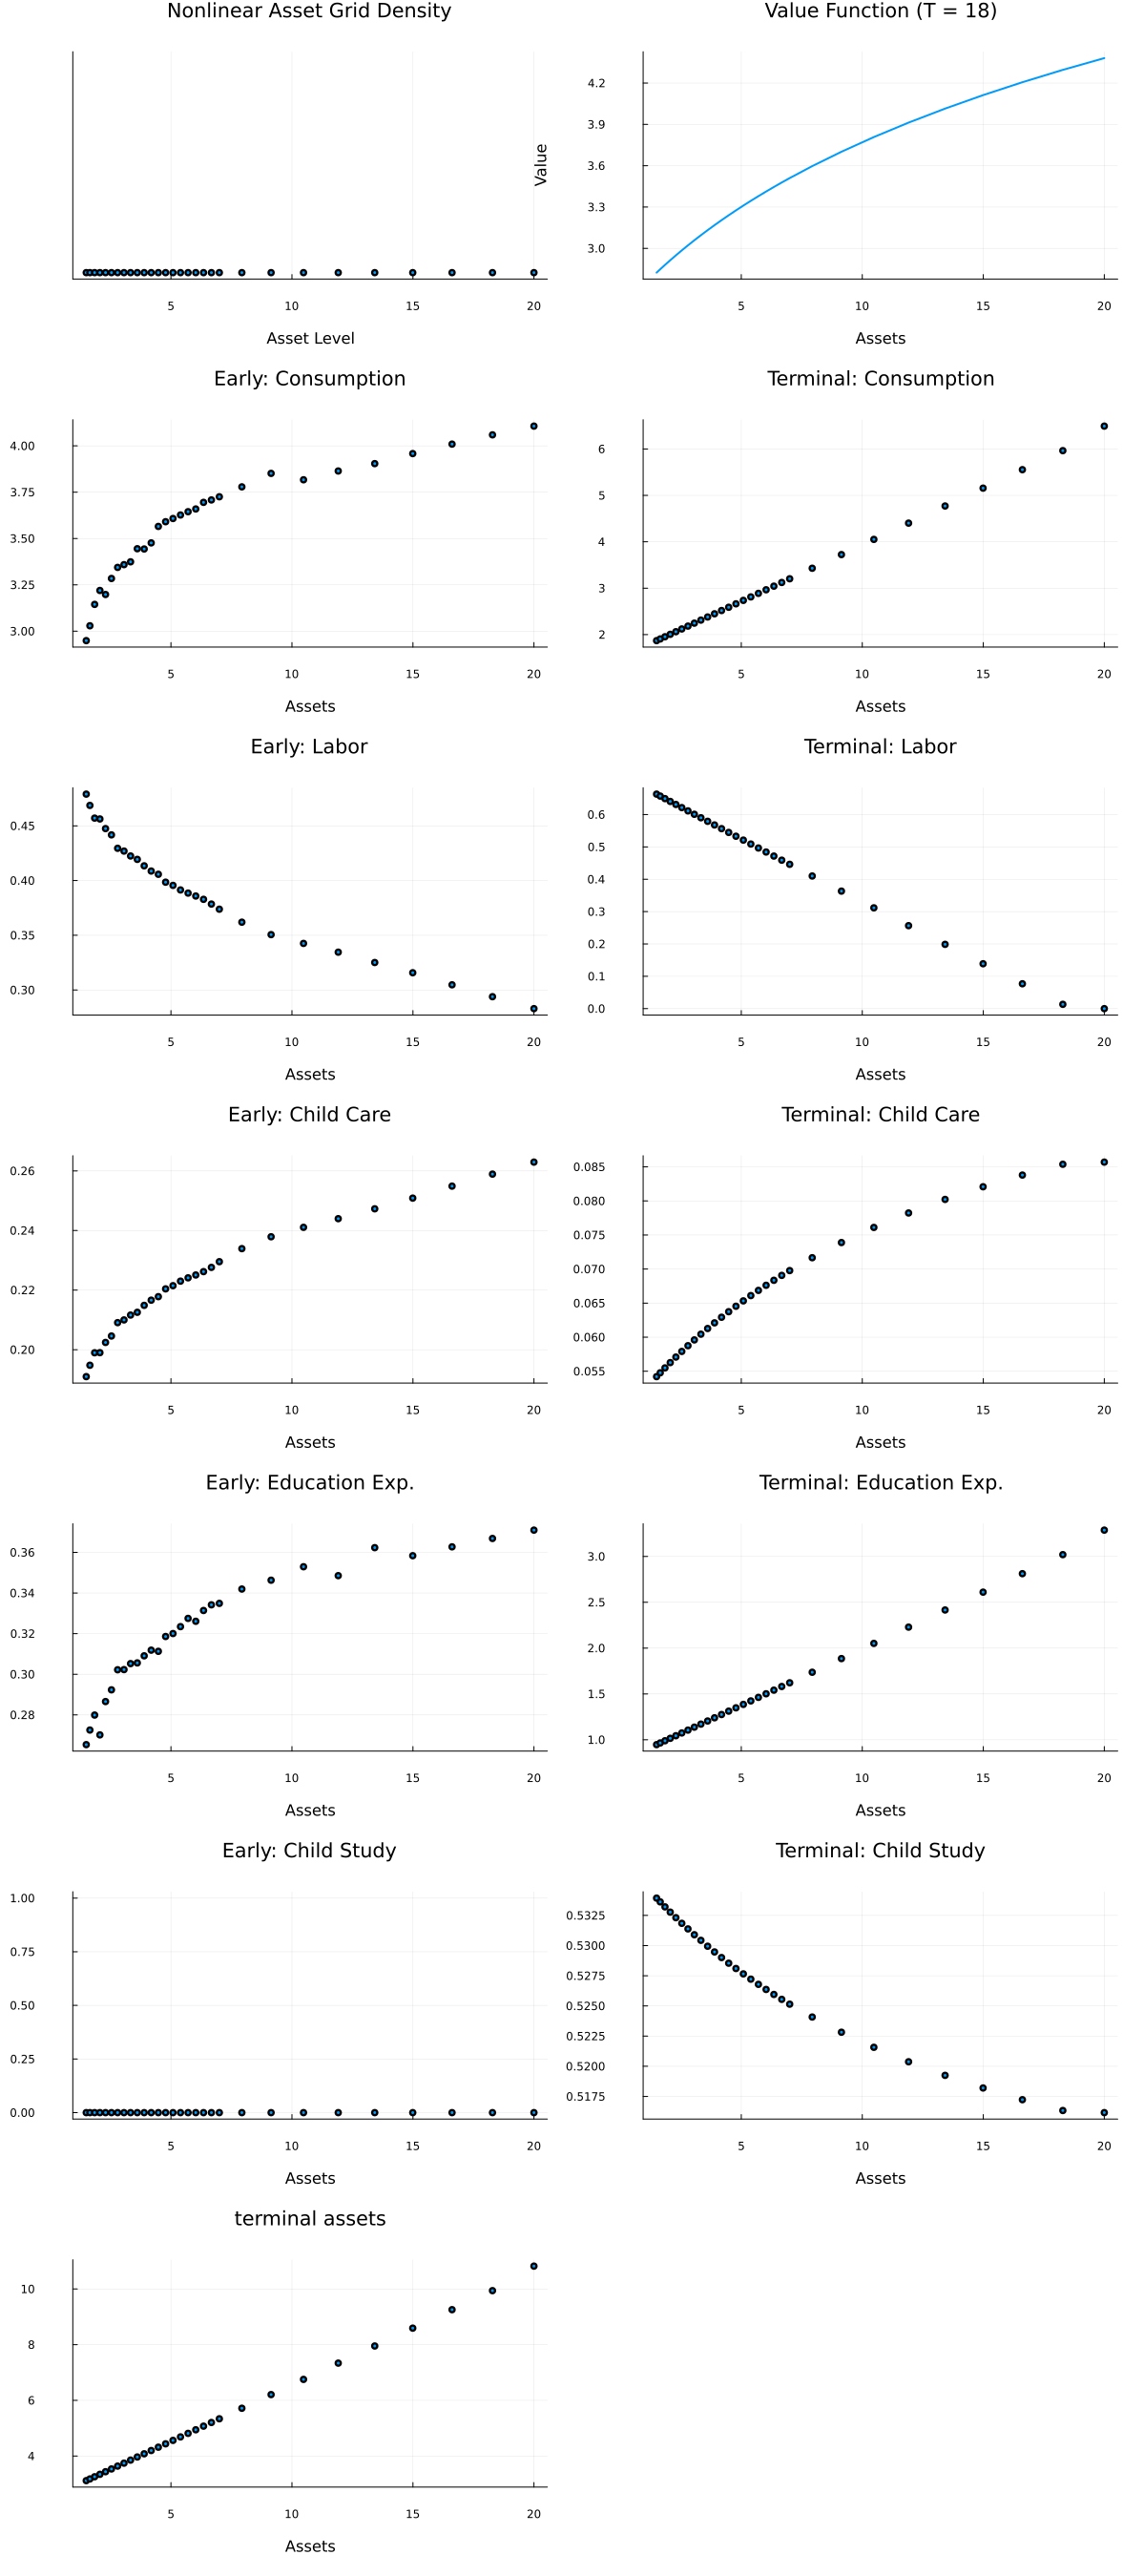

In [7]:
# Indices
k_mid = Int(ceil(length(model_baseline.k_grid) / 2))
hc_mid = Int(ceil(length(model_baseline.hc_grid) / 2))
T_terminal = model_baseline.T
t_early = 2
a_grid = model_baseline.a_grid

# 1. Nonlinear asset grid
p1 = scatter(
    a_grid, zeros(length(a_grid));
    xlabel = "Asset Level", yticks = [],
    title = "Nonlinear Asset Grid Density",
    markersize = 3, legend = false)

p2 = plot(
    a_grid, model_baseline.sol_v[T_terminal, :, k_mid, hc_mid];
    xlabel = "Assets", ylabel = "Value",
    title = "Value Function (T = $(T_terminal))",
    label = "Vₜ(a)", linewidth = 2)

# 2. Consumption
p3 = scatter(
    a_grid, model_baseline.sol_c[t_early, :, k_mid, hc_mid];
    xlabel = "Assets", ylabel = "Consumption",
    title = "Early: Consumption", label = "cₜ(a)", markersize = 3)
p4 = scatter(
    a_grid, model_baseline.sol_c[T_terminal, :, k_mid, hc_mid];
    xlabel = "Assets", ylabel = "",
    title = "Terminal: Consumption", label = "cₜ(a)", markersize = 3)

# 3. Labor
p5 = scatter(
    a_grid, model_baseline.sol_h[t_early, :, k_mid, hc_mid];
    xlabel = "Assets", ylabel = "Labor",
    title = "Early: Labor", label = "hₜ(a)", markersize = 3)
p6 = scatter(
    a_grid, model_baseline.sol_h[T_terminal, :, k_mid, hc_mid];
    xlabel = "Assets", ylabel = "",
    title = "Terminal: Labor", label = "hₜ(a)", markersize = 3)

# 4. Child care time
p7 = scatter(
    a_grid, model_baseline.sol_t[t_early, :, k_mid, hc_mid];
    xlabel = "Assets", ylabel = "Child Care",
    title = "Early: Child Care", label = "tₜ(a)", markersize = 3)
p8 = scatter(
    a_grid, model_baseline.sol_t[T_terminal, :, k_mid, hc_mid];
    xlabel = "Assets", ylabel = "",
    title = "Terminal: Child Care", label = "tₜ(a)", markersize = 3)

# 5. Education expenditure
p9 = scatter(
    a_grid, model_baseline.sol_e[t_early, :, k_mid, hc_mid];
    xlabel = "Assets", ylabel = "Education Exp.",
    title = "Early: Education Exp.", label = "eₜ(a)", markersize = 3)
p10 = scatter(
    a_grid, model_baseline.sol_e[T_terminal, :, k_mid, hc_mid];
    xlabel = "Assets", ylabel = "",
    title = "Terminal: Education Exp.", label = "eₜ(a)", markersize = 3)

# 6. Child study time (i_c)
p11 = scatter(
    a_grid, model_baseline.sol_i[t_early, :, k_mid, hc_mid];
    xlabel = "Assets", ylabel = "Child Study",
    title = "Early: Child Study", label = "iₜ(a)", markersize = 3)
p12 = scatter(
    a_grid, model_baseline.sol_i[T_terminal, :, k_mid, hc_mid];
    xlabel = "Assets", ylabel = "",
    title = "Terminal: Child Study", label = "iₜ(a)", markersize = 3)

p13 = scatter(a_grid, model_baseline.terminal_asset[:,k_mid, hc_mid];
         xlabel = "Assets", ylabel = "terminal assets",
         title = "terminal assets", markersize = 3)

# Combine all plots into a 6×2 grid
plot(
    p1,  p2,
    p3,  p4,
    p5,  p6,
    p7,  p8,
    p9,  p10,
    p11, p12,
    p13,
    layout = (7, 2),
    size = (1200, 2700),
    margin = 5mm,
    legend = false
)

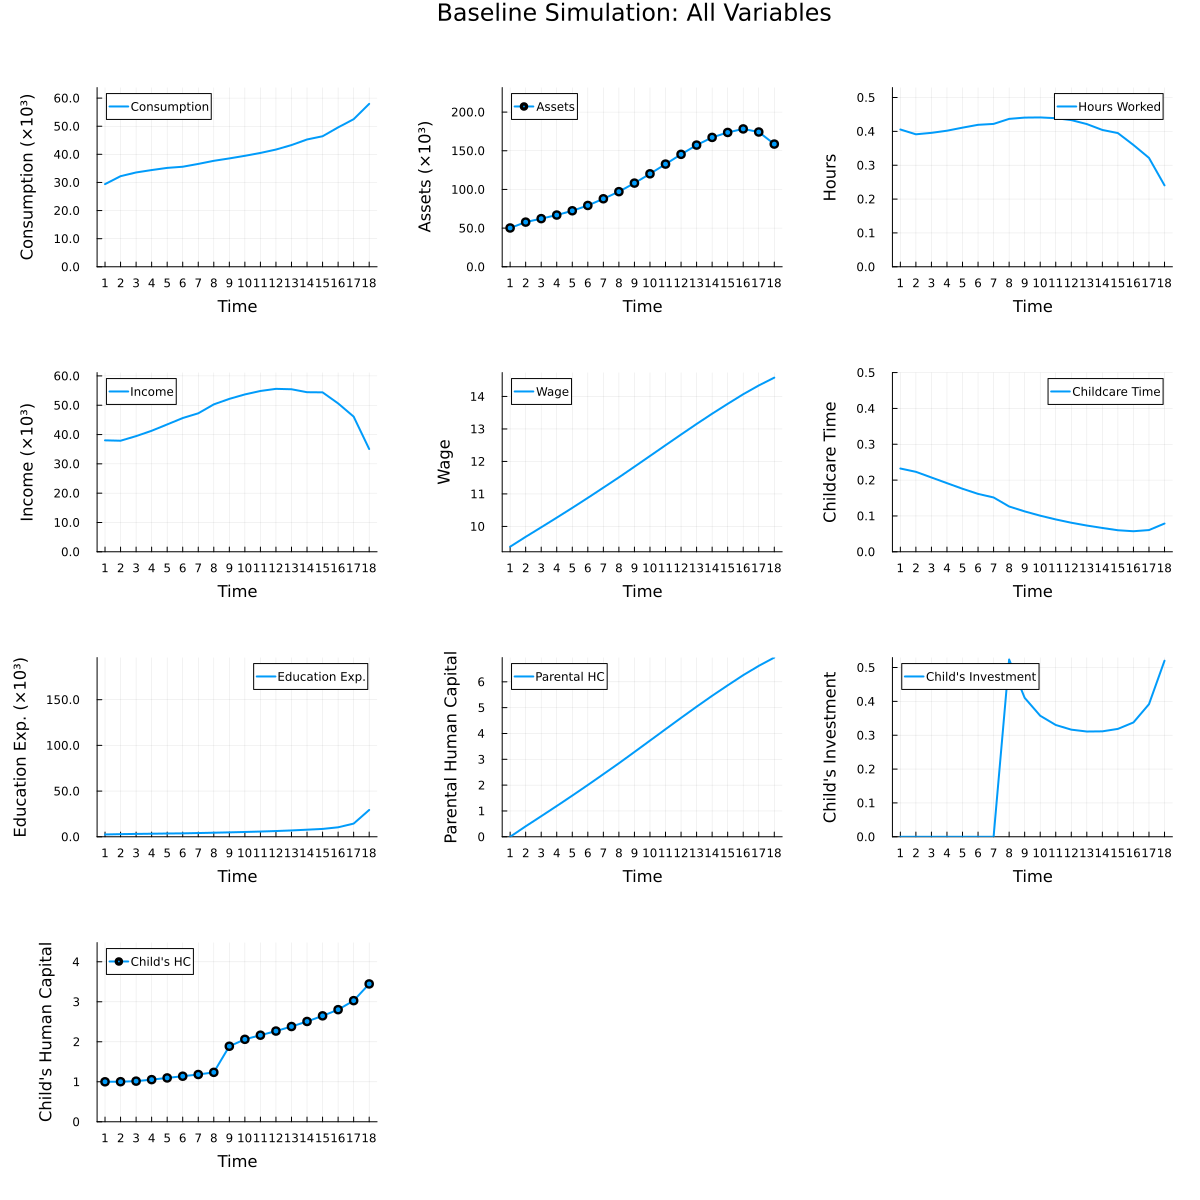

In [8]:
using Plots, Statistics

# --- Extraction Function ---
function extract_all(model)
    return (
        c      = mean(model.sim_c, dims=1)[:],
        a      = mean(model.sim_a, dims=1)[:],      # length T+1
        h      = mean(model.sim_h, dims=1)[:],
        k      = mean(model.sim_k, dims=1)[:],
        t      = mean(model.sim_t, dims=1)[:],
        e      = mean(model.sim_e, dims=1)[:],
        i      = mean(model.sim_i, dims=1)[:],
        hc     = mean(model.sim_hc, dims=1)[:],     # length T+1
        income = mean(model.sim_income, dims=1)[:],
        wage   = mean(model.sim_wage, dims=1)[:]
    )
end

# --- Extract Data ---
base = extract_all(model_baseline)
T = model_baseline.T
t = 1:T                # For main period-by-period plots
t_full = 1:(T+1)       # For terminal value plots (optional)

# --- Scaled Variables for Plotting ---
c_plot      = base.c .* 10
a_plot      = base.a[1:end-1] .* 10          # align to t = 1:T
income_plot = base.income .* 10
e_plot      = base.e .* 10
a_plot_full = base.a .* 10
hc_plot_full = base.hc .* 1 

# --- y-axis Maximums ---
ymax_c      = maximum(vcat(base.c, base.income)) * 11
ymax_a      = maximum(vcat(base.c, base.a[1:end-1], base.income)) * 13
ymax_income = maximum(base.income) * 11
ymax_wage   = maximum(base.wage)
ymax_e      = maximum(vcat(base.c, base.a[1:end-1], base.income)) * 11
ymax_hc     = maximum(base.hc[1:end-1]) * 1.3
ymax_k      = maximum(base.k)
ymax_h      = maximum(vcat(base.h, base.t)) * 1.2
ymax_t      = maximum(base.t)

thousand_formatter2(y) = string(round(y; digits=2))

# --- Individual Plots ---
p1  = plot(t, c_plot, label="Consumption", lw=2, xlabel="Time", ylabel="Consumption (×10³)",
           yformatter=thousand_formatter2, ylim=(0, ymax_c), xticks=t)

p2 = plot(t, a_plot_full, label="Assets", lw=2, marker=:circle,
          xlabel="Time", ylabel="Assets (×10³)", yformatter=thousand_formatter2, ylim=(0, ymax_a), xticks=t_full)

p3  = plot(t, base.h, label="Hours Worked", lw=2, xlabel="Time", ylabel="Hours", ylim=(0, ymax_h), xticks=t)

p4  = plot(t, base.k, label="Parental HC", lw=2, xlabel="Time", ylabel="Parental Human Capital", ylim=(0, ymax_k), xticks=t)

p5  = plot(t, e_plot, label="Education Exp.", lw=2, xlabel="Time", ylabel="Education Exp. (×10³)",
           yformatter=thousand_formatter2, ylim=(0, ymax_e), xticks=t)

p6 = plot(t, hc_plot_full, label="Child's HC", lw=2, marker=:circle,
          xlabel="Time", ylabel="Child's Human Capital", ylim=(0, ymax_hc), xticks=t_full)

p7  = plot(t, base.t, label="Childcare Time", lw=2, xlabel="Time", ylabel="Childcare Time", ylim=(0, 0.5), xticks=t)

p8  = plot(t, income_plot, label="Income", lw=2, xlabel="Time", ylabel="Income (×10³)",
           yformatter=thousand_formatter2, ylim=(0, ymax_income), xticks=t)

p9  = plot(t, base.wage, label="Wage", lw=2, xlabel="Time", ylabel="Wage", xticks=t)

p10 = plot(t, base.i, label="Child's Investment", lw=2, xlabel="Time", ylabel="Child's Investment",
           yformatter=thousand_formatter2, ylim=(0, ymax_h), xticks=t)

# --- Combined Plot ---
combined_plot = plot(p1, p2, p3, p8, p9, p7, p5, p4, p10, p6,
                     layout=(4, 3),
                     size=(1200, 1200),
                     plot_title="Baseline Simulation: All Variables",
                     titlefont=16,
                     margin=5mm)

# --- (Optional) Terminal Asset/HC Plot ---
# Plot the terminal value as a dot or a full trajectory, if you like
# Example:
# plot(t_full, base.a .* 10, label="Assets (including terminal)", ...)

display(combined_plot)